In [1]:
!pip install statsmodels pandas numpy matplotlib

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

In [3]:
from google.colab import files
uploaded = files.upload()


Saving Complete Datset.xlsx to Complete Datset.xlsx


In [4]:
macro_data = pd.read_excel("/content/Complete Datset.xlsx")

In [5]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] > 0.05:
        print("Data is NOT stationary. Differencing is needed.")
    else:
        print("Data is stationary.")

# Test each column for stationarity
for column in macro_data.columns:
    print(f"\nChecking stationarity for {column}:")
    check_stationarity(macro_data[column])



Checking stationarity for Quarter:
ADF Statistic: 0.1623524584666719
p-value: 0.9700692271853774
Data is NOT stationary. Differencing is needed.

Checking stationarity for Real GDP Growth:
ADF Statistic: -12.157297298843448
p-value: 1.5216933999310289e-22
Data is stationary.

Checking stationarity for Personal consumption expenditures (PCE):
ADF Statistic: -12.127590796537646
p-value: 1.766004308518772e-22
Data is stationary.

Checking stationarity for Unemployment Rate:
ADF Statistic: -2.8520496465252405
p-value: 0.051214863841046204
Data is NOT stationary. Differencing is needed.

Checking stationarity for Fed Funds Rate:
ADF Statistic: -4.135335498097103
p-value: 0.0008461608082796116
Data is stationary.


In [6]:
# Apply first differencing to non-stationary variables
macro_data_diff = macro_data.diff().dropna()
macro_data_diff.set_index("Quarter", inplace=True)
macro_data_diff = macro_data_diff.apply(pd.to_numeric, errors="coerce")
print(macro_data_diff.dtypes)

Real GDP Growth                            float64
Personal consumption expenditures (PCE)    float64
Unemployment Rate                          float64
Fed Funds Rate                             float64
dtype: object


In [7]:
from statsmodels.tsa.api import VAR

# Create the VAR model
model = VAR(macro_data_diff)

lag_selection = model.select_order(maxlags=8)
print(lag_selection.summary())
selected_lag = lag_selection.aic
var_model = model.fit(selected_lag)

print(var_model.summary())

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       4.323       4.434       75.44       4.368
1      0.9720      1.524*       2.644       1.195
2      0.6995       1.693       2.018       1.100
3      0.4525       1.887       1.585      1.031*
4      0.3968       2.273      1.514*       1.154
5      0.5580       2.876       1.807       1.493
6      0.4251       3.184       1.621       1.538
7     0.3620*       3.563       1.575       1.653
8      0.4038       4.046       1.719       1.873
-------------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 07, Apr, 2025
Time:                     14:22:00
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    3.68198
Nobs:                     92.0000    

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [8]:
macro_data_diff.index = pd.period_range(start="2000Q1", periods=len(macro_data_diff), freq="Q")

# Start the forecasting part here
forecast_steps = 6
forecast = var_model.forecast(y=macro_data_diff.values[-7:], steps=forecast_steps)

forecast_df = pd.DataFrame(forecast, columns=macro_data_diff.columns)
future_dates = pd.period_range(start=macro_data_diff.index[-1] + 1, periods=forecast_steps, freq="Q")
forecast_df.index = future_dates

last_values = macro_data.iloc[-1]
forecast_df = forecast_df.cumsum() + last_values

# Print the forecast
print(forecast_df)

       Fed Funds Rate Personal consumption expenditures (PCE) Quarter  \
2024Q4       4.222702                                2.883332     NaN   
2025Q1       3.891543                                0.341523     NaN   
2025Q2       3.531963                                4.194384     NaN   
2025Q3       3.321819                                2.994333     NaN   
2025Q4       3.262017                                3.448223     NaN   
2026Q1       3.259018                                4.209077     NaN   

       Real GDP Growth Unemployment Rate  
2024Q4        2.871632          4.227125  
2025Q1        1.118688          4.931132  
2025Q2        3.018601           5.01413  
2025Q3        2.850671          5.025525  
2025Q4        2.805656          4.991045  
2026Q1        3.156026          4.949311  


In [9]:
# Convert macro_data index from RangeIndex to DatetimeIndex
macro_data.index = pd.date_range(start="2000-01-01", periods=len(macro_data), freq="Q")

# Convert forecast_df index from PeriodIndex to DatetimeIndex
forecast_df.index = forecast_df.index.to_timestamp()


<ipython-input-9-81bf824fb6a5>:2: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  macro_data.index = pd.date_range(start="2000-01-01", periods=len(macro_data), freq="Q")


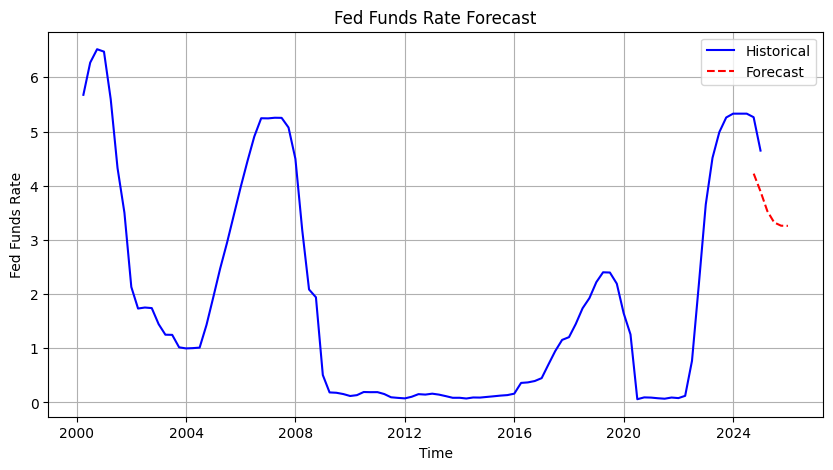

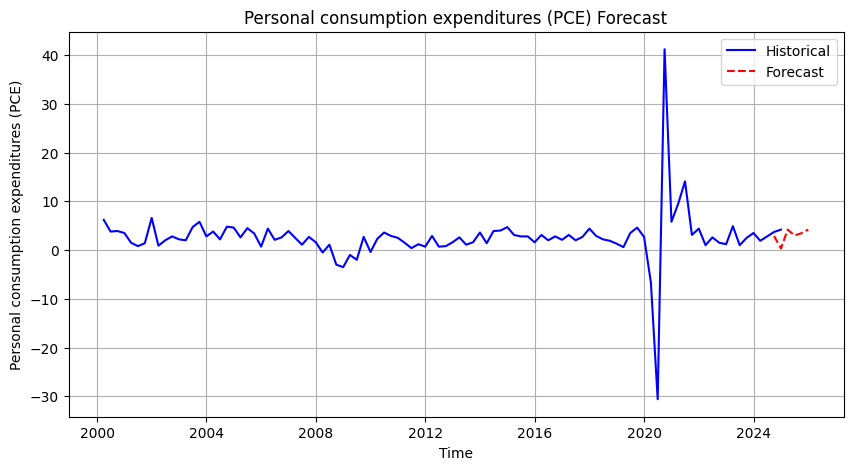

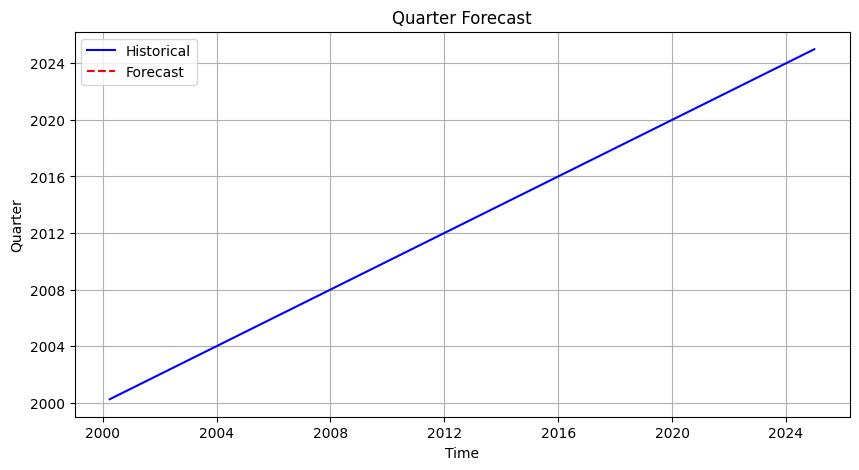

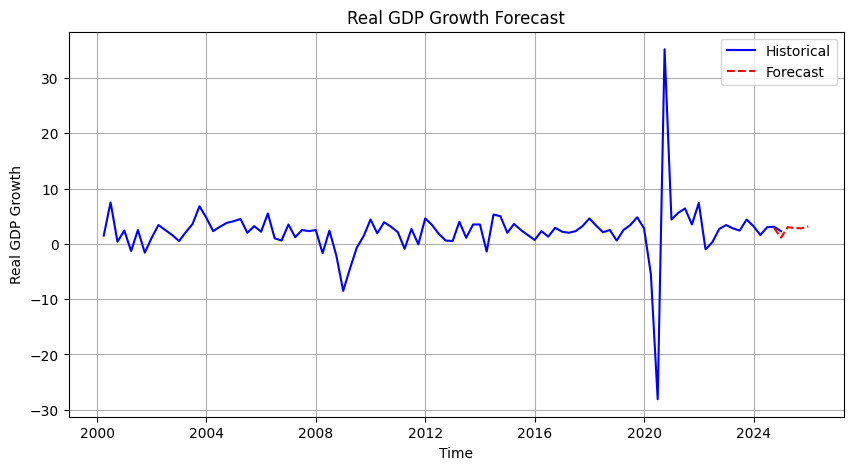

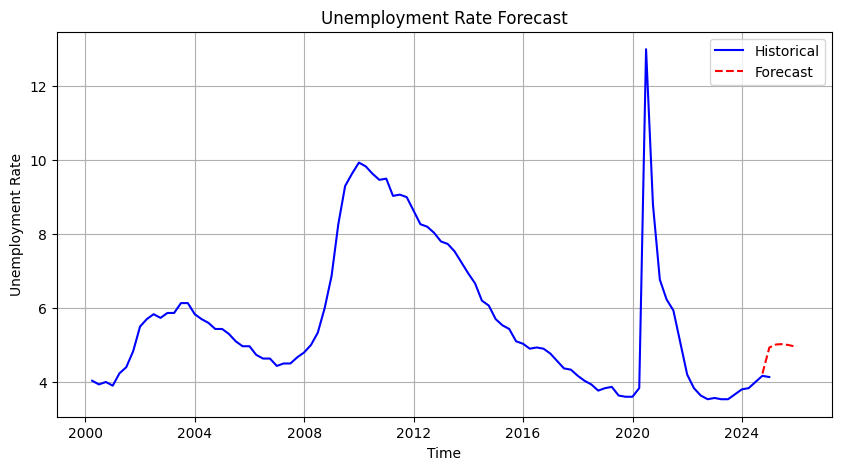

In [10]:
import matplotlib.pyplot as plt

for column in forecast_df.columns:
    plt.figure(figsize=(10, 5))
    plt.plot(macro_data.index, macro_data[column], label="Historical", color="blue")
    plt.plot(forecast_df.index, forecast_df[column], linestyle="dashed", label="Forecast", color="red")
    plt.title(f"{column} Forecast")
    plt.xlabel("Time")
    plt.ylabel(column)
    plt.legend()
    plt.grid(True)
    plt.show()
